In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

import time
from glob import glob
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras import backend as K
from keras.utils import plot_model

from keras.layers import Activation, Dense, LSTM, GRU, Bidirectional, AveragePooling1D, GlobalAveragePooling1D, Dropout, Flatten, BatchNormalization, TimeDistributed, Input, Reshape, RepeatVector, Concatenate, GlobalMaxPooling1D 
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D


#GPU 자원이 부족
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
raw_data = pd.read_csv('C:/Users/sjkan/Desktop/연세/YBIGTA/22 여름방학/신입기수프로젝트/rawdata.csv')
raw_data = raw_data[:-6912]

In [ ]:
# 날짜를 index로 바꾸고 dtype을 datetime으로 바꾸기
raw_data.set_index(keys = ['날짜'], inplace = True)
raw_data.index = pd.to_datetime(raw_data.index, format = '%Y-%m-%d %H:%M')

In [ ]:
raw_data.isnull().sum()

현재수위          707
유입량           707
저수량           707
공용량           707
방류량           707
강화대교_조위      4923
청담대교_유량     15164
잠수교_유량     189937
한강대교_유량      1279
행주대교_유량        59
대곡교_강수량         0
진관교_강수량         0
송정동_강수량         0
청담대교_수위        59
잠수교_수위         59
한강대교_수위        59
행주대교_수위        59
dtype: int64

In [ ]:
raw_data

,현재수위,유입량,저수량,공용량,방류량,강화대교_조위,청담대교_유량,잠수교_유량,한강대교_유량,행주대교_유량,대곡교_강수량,진관교_강수량,송정동_강수량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
날짜,,,,,,,,,,,,,,,,,
2012-05-01 00:00:00,24.800,555.00,219.07,24.93,555.00,445.0,469.05,0.0,729.80,540.18,0.0,0.0,0.0,310.7,300.2,290.0,275.3
2012-05-01 00:10:00,24.794,464.60,218.86,25.15,562.90,449.0,498.00,0.0,731.48,540.18,0.0,0.0,0.0,314.7,300.2,290.0,275.3
2012-05-01 00:20:00,24.789,478.10,218.69,25.31,576.40,451.0,490.68,0.0,726.42,540.18,0.0,0.0,0.0,313.7,301.2,290.0,275.3
2012-05-01 00:30:00,24.789,464.80,218.69,25.31,563.10,452.0,476.21,0.0,726.42,552.17,0.0,0.0,0.0,311.7,301.2,290.0,276.3
2012-05-01 00:40:00,24.789,478.10,218.69,25.31,576.40,450.0,476.21,0.0,707.17,564.29,0.0,0.0,0.0,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31 23:10:00,25.180,140.94,217.99,26.01,140.94,220.0,285.72,NaN,575.57,493.58,0.0,0.0,0.0,281.7,281.2,278.0,271.3
2022-05-31 23:20:00,25.180,141.07,217.99,26.01,141.07,208.0,274.78,NaN,501.04,505.03,0.0,0.0,0.0,279.7,279.2,278.0,272.3
2022-05-31 23:30:00,25.180,141.01,217.99,26.01,141.01,196.0,269.40,NaN,425.89,505.03,0.0,0.0,0.0,278.7,277.2,277.0,272.3


In [ ]:
from glob import glob

xdata = pd.read_csv("C:/Users/sjkan//Desktop/행주대교_유량 수위x4 완성.csv", encoding = 'cp949')
xdata

,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,540.18,310.7,300.2,290.0,275.3
1,540.18,314.7,300.2,290.0,275.3
2,540.18,313.7,301.2,290.0,275.3
3,552.17,311.7,301.2,290.0,276.3
4,564.29,311.7,301.2,291.0,277.3
...,...,...,...,...,...
276331,974.40,288.0,295.0,299.0,306.0
276332,1006.88,287.0,303.0,304.0,308.0
276333,1039.90,299.0,307.0,309.0,310.0
276334,1073.46,309.0,311.0,314.0,312.0


In [ ]:
xdata = xdata[:-6912]
xdata

,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,540.18,310.7,300.2,290.0,275.3
1,540.18,314.7,300.2,290.0,275.3
2,540.18,313.7,301.2,290.0,275.3
3,552.17,311.7,301.2,290.0,276.3
4,564.29,311.7,301.2,291.0,277.3
...,...,...,...,...,...
269419,493.58,281.7,281.2,278.0,271.3
269420,505.03,279.7,279.2,278.0,272.3
269421,505.03,278.7,277.2,277.0,272.3
269422,493.58,277.7,276.2,276.0,271.3


In [ ]:
# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = xdata.copy()

for i in range(len(xdata.columns)):
    scaler = MinMaxScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x

# 원하는 칼럼명 입력하기

In [ ]:
#ydata = raw_data[['현재수위','유입량','저수량','공용량','방류량','강화대교_조위','청담대교_유량','잠수교_유량','한강대교_유량']]
ydata = raw_data[['강화대교_조위']]

# 원하는 칼럼명 입력하기

In [ ]:
ydata = ydata.reset_index()
ydata = ydata.강화대교_조위
ydata = pd.DataFrame(ydata)
ydata

,강화대교_조위
0,445.0
1,449.0
2,451.0
3,452.0
4,450.0
...,...
269419,220.0
269420,208.0
269421,196.0
269422,184.0


In [ ]:
input_regular = pd.concat([input_x_regular, ydata], axis = 1)
input_regular

,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,강화대교_조위
0,0.011070,0.049611,0.060000,0.051621,0.056478,445.0
1,0.011070,0.053502,0.060000,0.051621,0.056478,449.0
2,0.011070,0.052529,0.061111,0.051621,0.056478,451.0
3,0.011475,0.050584,0.061111,0.051621,0.058140,452.0
4,0.011883,0.050584,0.061111,0.052821,0.059801,450.0
...,...,...,...,...,...,...
269419,0.009498,0.021401,0.038889,0.037215,0.049834,220.0
269420,0.009884,0.019455,0.036667,0.037215,0.051495,208.0
269421,0.009884,0.018482,0.034444,0.036014,0.051495,196.0
269422,0.009498,0.017510,0.033333,0.034814,0.049834,184.0


# 원하는 칼럼명 입력하기

In [ ]:
input_y_ = input_regular[['강화대교_조위']]
input_x_ = input_regular.drop(input_y_.columns, axis = 1)

In [ ]:
input_x_

,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,0.011070,0.049611,0.060000,0.051621,0.056478
1,0.011070,0.053502,0.060000,0.051621,0.056478
2,0.011070,0.052529,0.061111,0.051621,0.056478
3,0.011475,0.050584,0.061111,0.051621,0.058140
4,0.011883,0.050584,0.061111,0.052821,0.059801
...,...,...,...,...,...
269419,0.009498,0.021401,0.038889,0.037215,0.049834
269420,0.009884,0.019455,0.036667,0.037215,0.051495
269421,0.009884,0.018482,0.034444,0.036014,0.051495
269422,0.009498,0.017510,0.033333,0.034814,0.049834


In [ ]:
input_y_.isnull().sum()

강화대교_조위    4923
dtype: int64

# 원하는 칼럼명 입력하기

In [ ]:
nanIndex = input_y_[input_y_['강화대교_조위'].isnull() == True].index

In [ ]:
nanIndex

Int64Index([   193,    307,   1359,   1377,   1378,   1379,   1380,   1381,
              1382,   1383,
            ...
            264959, 265024, 265025, 265026, 265027, 265028, 265029, 266199,
            266290, 267172],
           dtype='int64', length=4923)

In [ ]:
from tqdm import tqdm

xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-1]
for i in range(len(input_regular.columns)-1):
    xdata_idx.append(i)

w =  149 #window size

idx = []
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:22<00:00,  7.52s/it]


In [ ]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(267785, 149, 5)
(267785, 1)


In [ ]:
# 나중에 학습된 모델에 이거 넣어서 predict해서 결측치 채우기
x_real_predict = []
y_real_predict = []

for i in range(len(nanIndex)):
    k = nanIndex[-(i+1)]
    
    x_real_predict.insert(0,(xdata[k - w * (k // 26496 + 1)]))
    y_real_predict.insert(0,(ydata[k - w * (k // 26496 + 1)]))
    
    xdata.pop(k - w * (k // 26496 + 1))
    ydata.pop(k - w * (k // 26496 + 1))

In [ ]:
print(np.array(x_real_predict).shape)
print(np.array(y_real_predict).shape)

(4923, 149, 5)
(4923, 1)


In [ ]:
y_real_predict

In [ ]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(262862, 149, 5)
(262862, 1)


In [ ]:
pd.DataFrame(ydata).isnull().sum()

0    0
dtype: int64

In [ ]:
xtrain = np.array(xdata[:-50000])
ytrain = np.array(ydata[:-50000])

xtest = np.array(xdata[-50000:])
ytest = np.array(ydata[-50000:])

In [ ]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(212862, 149, 5)
(212862, 1)
(50000, 149, 5)
(50000, 1)


## 모델 생성

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu', input_shape=(w, xtrain.shape[2])))
#model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
#model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())

model_enc_dec_cnn.add(RepeatVector(1))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(1))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =["accuracy"])

model_enc_dec_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 149, 64)           704       
                                                                 
 flatten (Flatten)           (None, 9536)              0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 9536)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 1, 200)            7789600   
                                                                 
 lstm_1 (LSTM)               (None, 1, 200)            320800    
                                                                 
 lstm_2 (LSTM)               (None, 1, 200)            320800    
                                                        

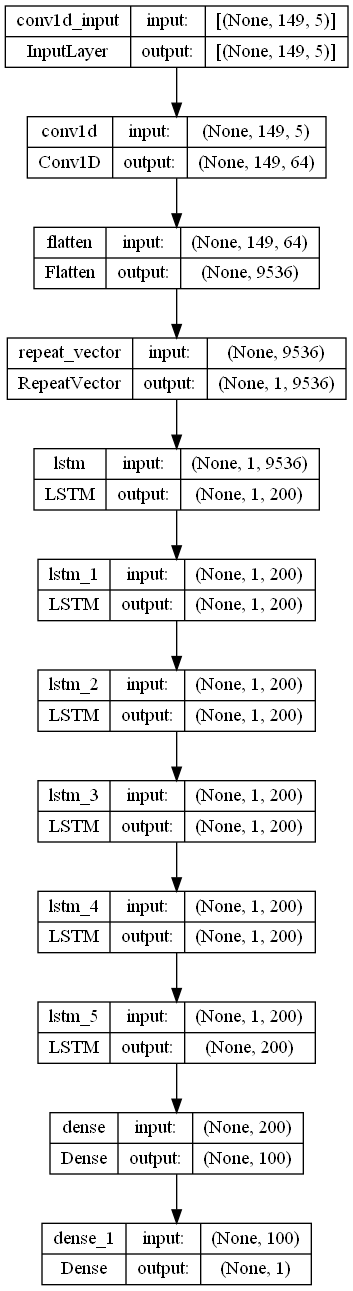

In [ ]:
plot_model(model=model_enc_dec_cnn, show_shapes=True)

In [ ]:
epochs = 100
batch_size = xtrain.shape[0] // 1000
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=0.001)

In [ ]:
## 학습

history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

In [ ]:
## 평가

keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

yhat = keras_model_best.predict(xtest, verbose=1)

yhat

keras_model_best.evaluate(xtest,ytest)

1563/1563 [==============================] - 24s 14ms/step - loss: 36.9579 - accuracy: 0.0000e+00


[36.957881927490234, 0.0]

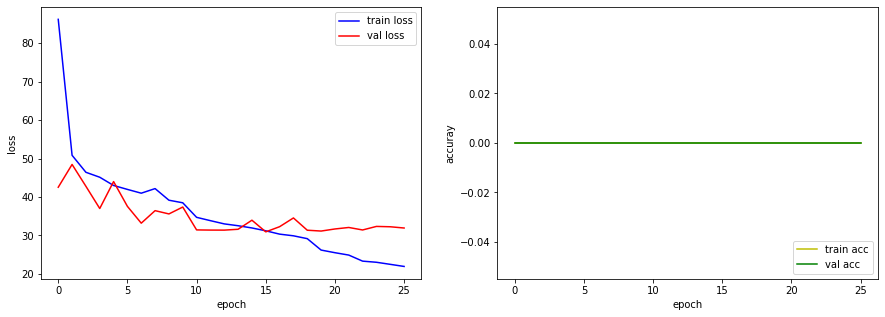

In [ ]:
## 학습 과정 시각화

fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['accuracy'], 'y', label='train acc')
loss_ax[1].plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('accuray')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

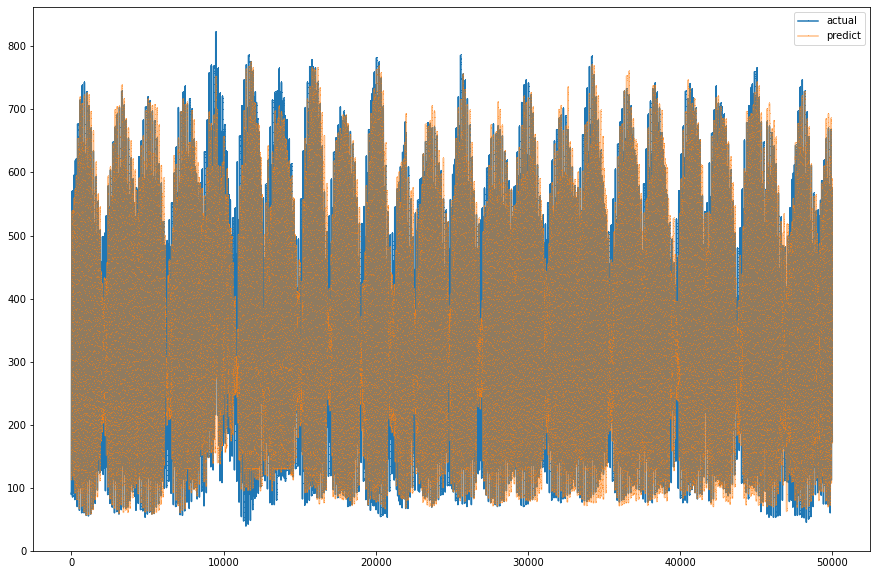

In [ ]:
## 결과 시각화

tl_predict = np.array(yhat)

#결과 시각화
plt.figure(figsize=(15,10))
plt.plot(ytest, marker = ",", label = "actual")
plt.plot(tl_predict, marker = ",", label="predict", alpha = 0.5)
plt.legend(prop={'size':10})  

plt.show()

In [ ]:
## 점수 확인
print("RMSE : ",float(root_mean_squared_error(ytest, tl_predict)))

RMSE :  56.097893823917


## 파일 저장
파일명에 '완성' 없으면 마지막 6912개는 raw data

# 원하는 칼럼명 입력하기

In [ ]:
raw_data2 = pd.read_csv('C:/Users/sjkan/Desktop/연세/YBIGTA/22 여름방학/신입기수프로젝트/rawdata.csv')
raw_data2 = raw_data2[:-6912]
predict_dataset = raw_data2['강화대교_조위']

In [ ]:
predict_dataset.info()

<class 'pandas.core.series.Series'>
RangeIndex: 269424 entries, 0 to 269423
Series name: 강화대교_조위
Non-Null Count   Dtype  
--------------   -----  
264501 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


In [ ]:
predict_dataset.isnull().sum()

4923

In [ ]:
predict_dataset.iloc[nanIndex[2]]

nan

In [ ]:
y_real_predict

In [ ]:
test_input = np.array(x_real_predict)
y_real_hat = keras_model_best.predict(test_input, verbose=1)

154/154 [==============================] - 3s 17ms/step


In [ ]:
y_real_hat

array([[210.08028],
       [498.692  ],
       [564.90247],
       ...,
       [202.64046],
       [232.57986],
       [395.48077]], dtype=float32)

In [ ]:
predict_dataset.info()

<class 'pandas.core.series.Series'>
RangeIndex: 269424 entries, 0 to 269423
Series name: 강화대교_조위
Non-Null Count   Dtype  
--------------   -----  
264501 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


In [ ]:
predict_dataset.isnull().sum()

4923

In [ ]:
for i in range(len(nanIndex)):
    predict_dataset.iloc[nanIndex[i]] = np.float64(y_real_hat[i])

In [ ]:
predict_dataset.info()

<class 'pandas.core.series.Series'>
RangeIndex: 269424 entries, 0 to 269423
Series name: 강화대교_조위
Non-Null Count   Dtype  
--------------   -----  
269424 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


In [ ]:
predict_dataset.isnull().sum()

0

# 원하는 칼럼명 입력하기

In [ ]:
addon = pd.read_csv('C:/Users/sjkan/Desktop/연세/YBIGTA/22 여름방학/신입기수프로젝트/rawdata.csv')
addon.set_index(keys = ['날짜'], inplace = True)
addon.index = pd.to_datetime(addon.index, format = '%Y-%m-%d %H:%M')
add = addon[['강화대교_조위']][-6912:]
add.isnull().sum()

강화대교_조위    4
dtype: int64

In [ ]:
add = add.interpolate()
add.isnull().sum()

강화대교_조위    0
dtype: int64

In [ ]:
add = add.reset_index()
add = add['강화대교_조위']
add = pd.DataFrame(add)
add

,강화대교_조위
0,162.0
1,151.0
2,141.0
3,130.0
4,120.0
...,...
6907,510.0
6908,492.0
6909,475.0
6910,458.0


In [ ]:
result = pd.concat([pd.DataFrame(predict_dataset), add], ignore_index = True)
result

,강화대교_조위
0,445.0
1,449.0
2,451.0
3,452.0
4,450.0
...,...
276331,510.0
276332,492.0
276333,475.0
276334,458.0


In [ ]:
result.isnull().sum()

강화대교_조위    0
dtype: int64

In [ ]:
result.to_csv('강화대교_조위_미루기전2.csv', index = False, encoding = 'cp949', columns = ['강화대교_조위'])